# 1. Importing Libraries
---

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold
from scipy.stats import randint, uniform, loguniform

# Avoid warnings to show-up
import warnings
warnings.filterwarnings('ignore')

# 2. Data Investigation
---

In [2]:
raw = pd.read_csv('covtype.csv')
raw

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [3]:
# There are 581012 rows and 55 columns in the dataset
# All columns are numerical
# It seems that there are no missing values in the dataset
# It is a big dataset with many features

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [4]:
# There are too many classes that are One Hot Encoded (OHE), I wonder if there are overlapping entries in these columns
# Let's separate OHE columns and the rest of the columns
soil_cols = [col for col in raw.columns if 'Soil_Type' in col]
wilderness_cols = [col for col in raw.columns if 'Wilderness_Area' in col]

ohe_cols = soil_cols + wilderness_cols

non_ohe_cols = [col for col in raw.columns if col not in ohe_cols]

# 3. Exploratory Data Analysis
---

In [5]:
# Let's see if there are overlapping entries in Soil_Type columns
# This is to check if any row has more than one Soil_Type marked as 1

for i, col in  enumerate(soil_cols):
    if raw[raw[col] == 1][soil_cols].sum().sum() > raw[raw[col] == 1][soil_cols].sum().iloc[i]:
        print(f'Warning: {col} has overlapping entries with other Soil_Type columns.')
    else:
        pass

# It seems that there are no overlapping entries in Soil_Type columns
# Hence, each row has only one Soil_Type marked as 1

In [6]:
# Let's see if there are overlapping entries in Wilderness_Area columns
# This is to check if any row has more than one Wilderness_Area marked as 1

for i, col in  enumerate(wilderness_cols):
    if raw[raw[col] == 1][wilderness_cols].sum().sum() > raw[raw[col] == 1][wilderness_cols].sum().iloc[i]:
        print(f'Warning: {col} has overlapping entries with other Wilderness_Area columns.')
    else:
        pass

# It seems that there are no overlapping entries in Wilderness_Area columns
# Hence, each row has only one Wilderness_Area marked as 1

<Axes: xlabel='Cover_Type'>

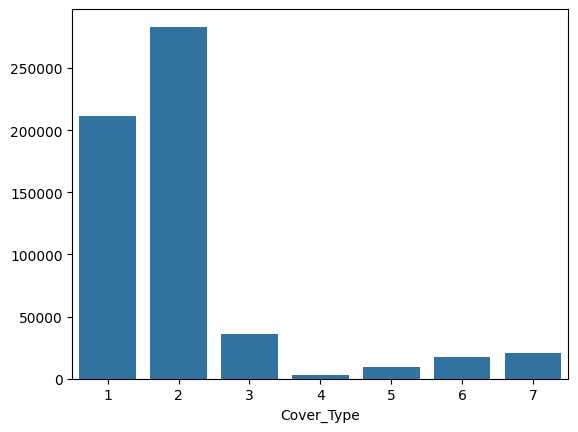

In [7]:
# Let's check the distribution of the target variable 'Cover_Type'
# It is a multi-class classification problem with 7 classes
# The classes are imbalanced, therefore we need to use stratified sampling

sns.barplot(x=raw['Cover_Type'].value_counts().index, y=raw['Cover_Type'].value_counts().values)

<Axes: xlabel='Cover_Type', ylabel='Elevation'>

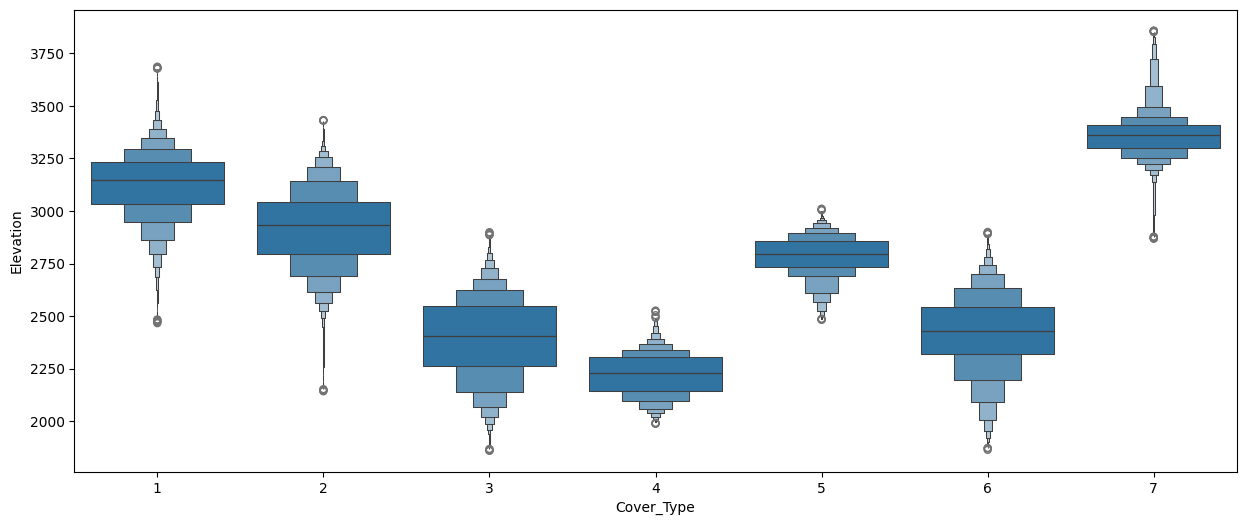

In [8]:
# Let's visualize the distribution of Elevation for each Cover_Type using boxenplot
plt.figure(figsize=(15,6))
sns.boxenplot(data=raw,y='Elevation',x='Cover_Type')

# It seems that Elevation plays a role in determining some of Cover_Types
# For example, Cover_Type 1 and 2 are generally found at higher elevations compared to Cover_Type 5 and 6

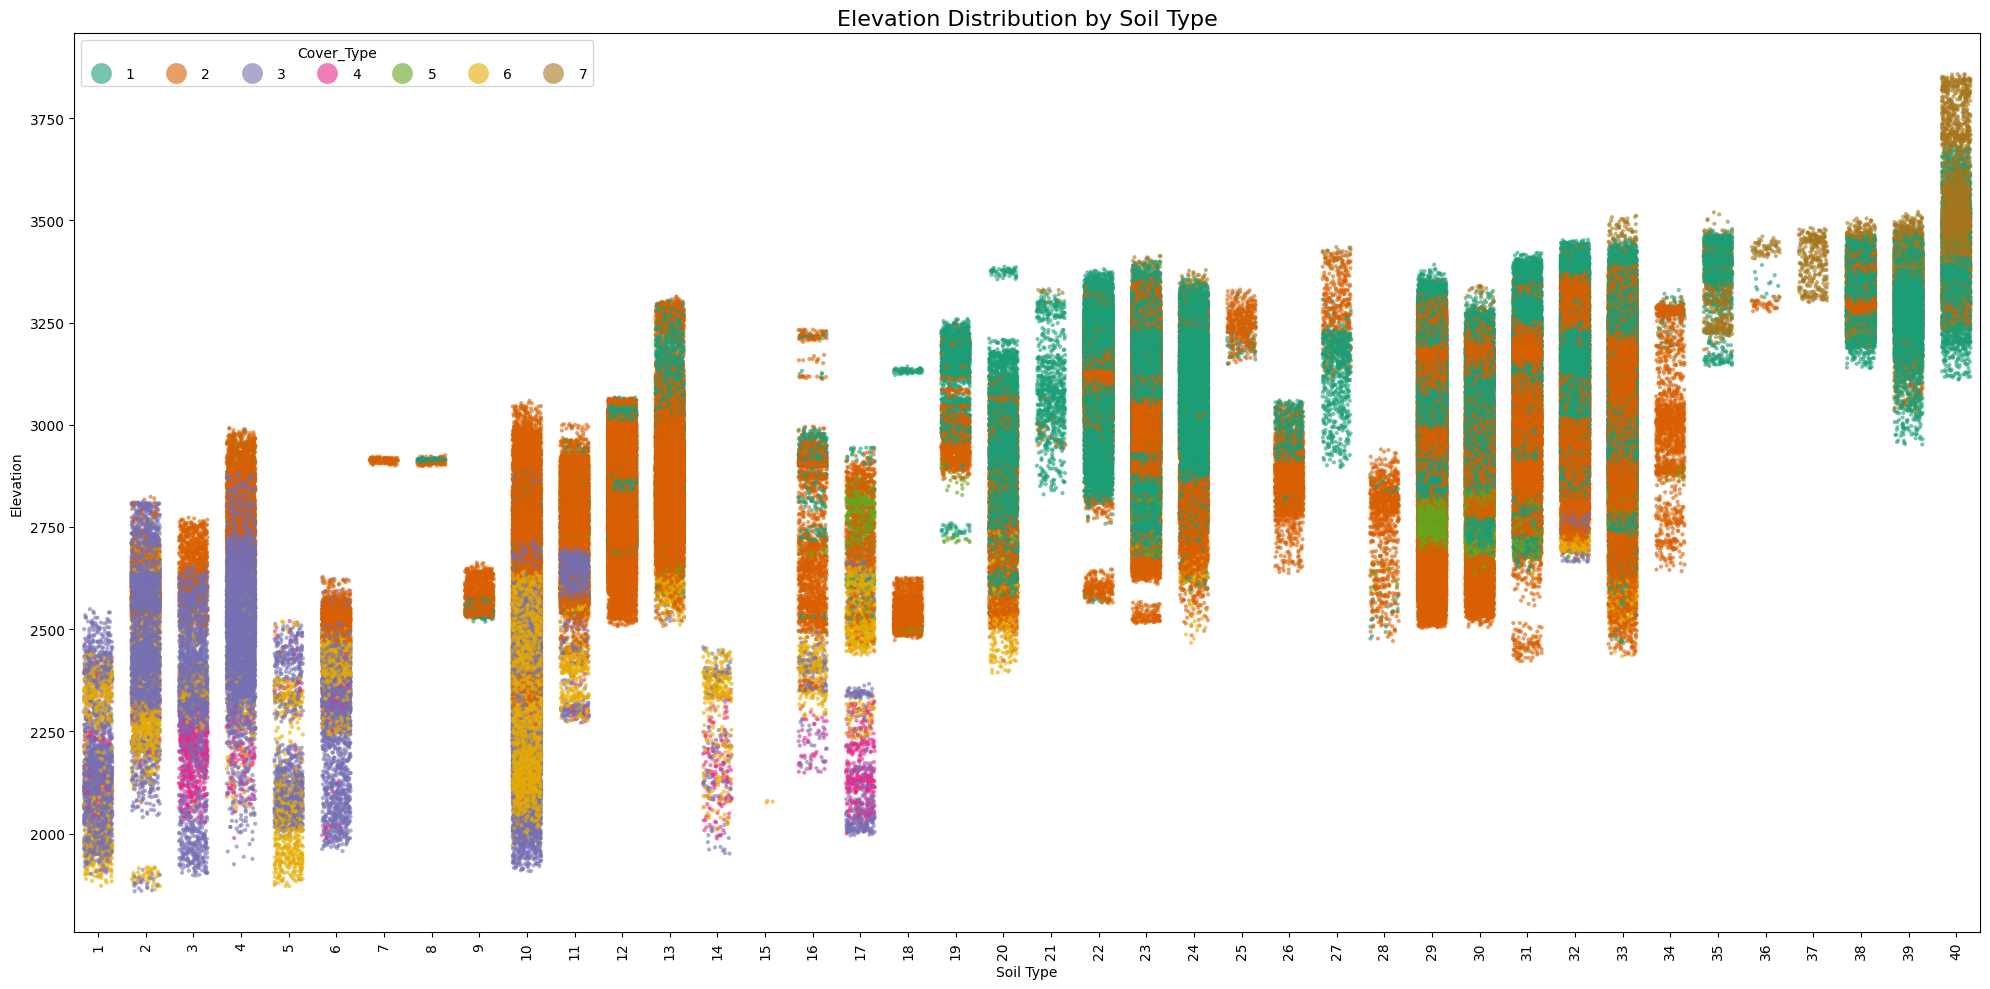

In [9]:
# We saw that Cover_Type has some relation with Elevation
# Now, let's check the relationship between Soil_Type and Elevation 
# I will also include Cover_Type in the visualization to see if there are any patterns

# Since the dataset is already One-Hot Encoded, we need to convert the one-hot encoded columns back to a single categorical column 'Soil_Type_Cat'
# idxmax will return the column name with the maximum value (which is 1 in this case) for each row (since there are no overlapping entries)
# I will then extract only the number from the column name to create a new column 'Soil_Type_Cat' (to make it easier to visualize)
raw['Soil_Type_Cat'] = raw[soil_cols].idxmax(axis=1).str.replace('Soil_Type', '').astype(int)

# Now, let's create the stripplot of Elevation for each Soil Type with Cover_Type as hue
plt.figure(figsize=(20, 10))
sns.stripplot(data=raw, x='Soil_Type_Cat', y='Elevation', hue='Cover_Type', alpha=0.6, size=3, jitter=0.3, palette='Dark2')
plt.title('Elevation Distribution by Soil Type', fontsize=16)
plt.xlabel('Soil Type')
plt.ylabel('Elevation')
plt.xticks(rotation=90)
plt.legend(title='Cover_Type', ncol=7, markerscale=5, fontsize=10, title_fontsize=10, )
plt.tight_layout()


# Soil Type is indeed related to Elevation and Cover Type
# Some soil types are exclusive to certain cover types, indicating a strong relationship between soil composition and vegetation type
# As we have already seen in the boxenplot, Cover_Type 1, 2, and 7 are generally found at higher elevations share common Soil_Types (especially Soil_Type >20)
# Cover_Type 3 and 4 are found at lower eleveations and also share common Soil_Types (especially Soil_Type <17)
# Ordinal Encoding might be really good for Soil_Type instead of One-Hot Encoding to reduce dimensionality and capture the inherent order in soil types based on elevation and cover type relationships

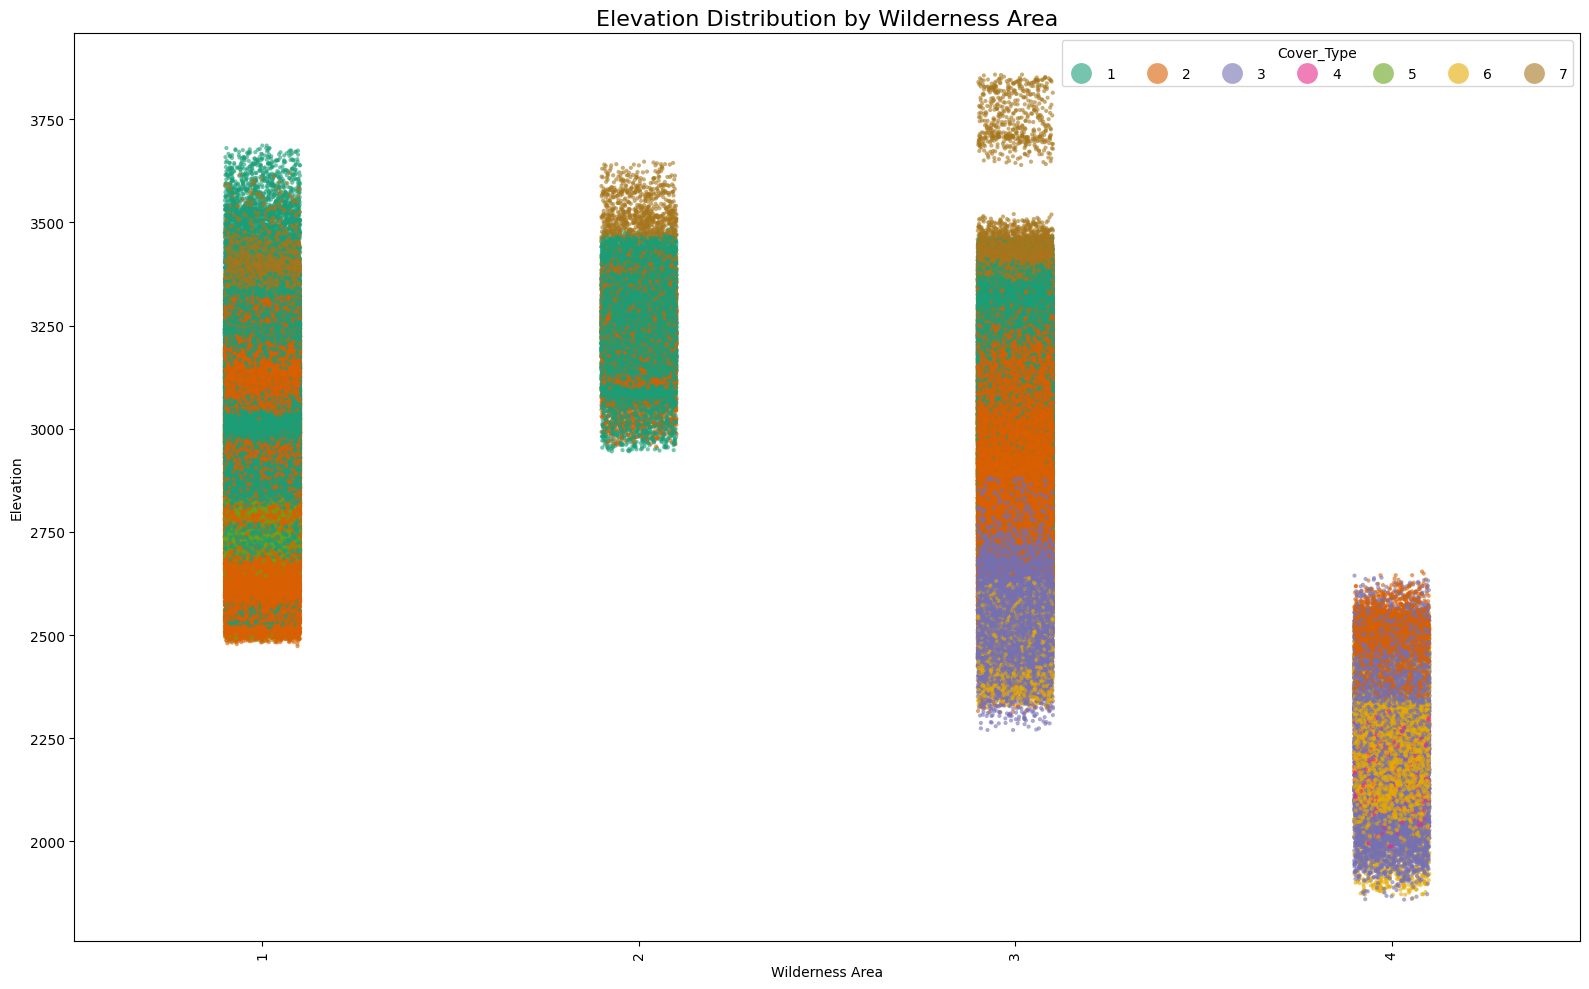

In [10]:
raw['Wilderness_Cat'] = raw[wilderness_cols].idxmax(axis=1).str.replace('Wilderness_Area', '').astype(int)

# Now, let's create the stripplot of Elevation for each Wilderness Area with Cover_Type as hue
plt.figure(figsize=(16, 10))
sns.stripplot(data=raw, x='Wilderness_Cat', y='Elevation', hue='Cover_Type', alpha=0.6, size=3, jitter=0.1, palette='Dark2')
plt.title('Elevation Distribution by Wilderness Area', fontsize=16)
plt.xlabel('Wilderness Area')
plt.ylabel('Elevation')
plt.xticks(rotation=90)
plt.legend(title='Cover_Type', ncol=7, markerscale=5, fontsize=10, title_fontsize=10, )
plt.tight_layout()

# Wilderness Area does not seem to have a strong relationship with Elevation
# However, some Wilderness Areas do show a tendency to be associated with certain Cover Types
# For example, Wilderness Area 1 seems to have a higher concentration of Cover_Type 1, Cover_Type 2, and Cover_Type 7 (very low or none of Cover_Type 3, 4, 5, 6)
# Wilderness Area 3 seems to have a broader distribution of Cover_Types, there is even a clear separation of some parts of Cover_Type 7 as the elevation increases, 
#   this area has the broadest cover of elevations, hence provides rich biodiversity unlike Wilderness Area 1
# Wilderness Area 4 seems to be associated with lower elevations and has a higher concentration of Cover_Type 1 and Cover_Type 7
# Since there is no clear relationship in between Wilderness Area and Elevation, One-Hot Encoding seems to be a good choice unlike Soil_Type columns

# Hence, I will drop the Wilderness_Cat column
raw.drop(columns='Wilderness_Cat',axis=1,inplace=True)

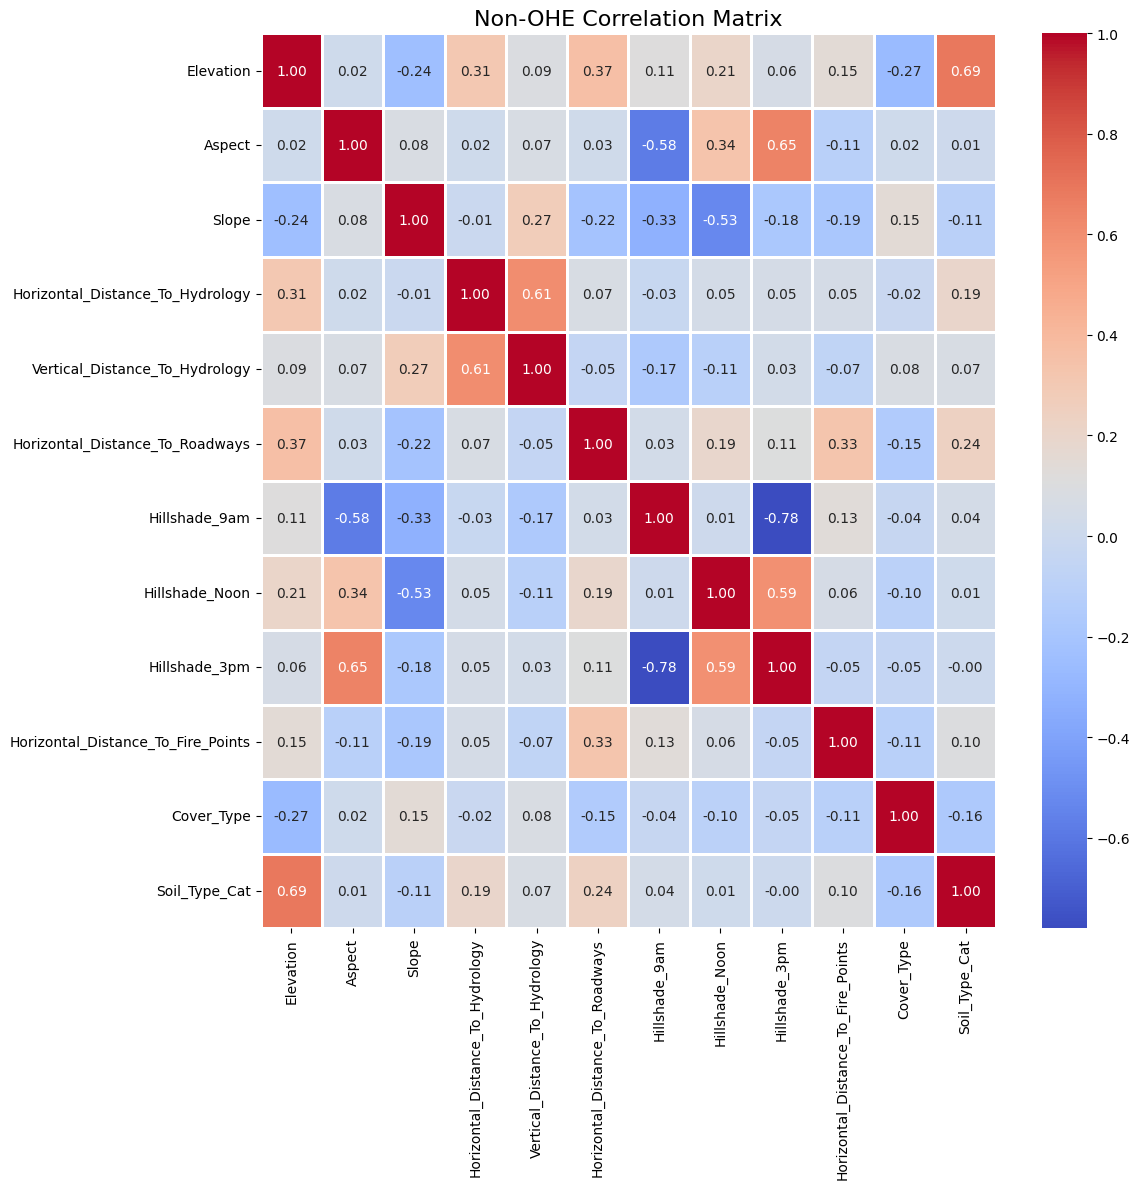

In [11]:
# Let's see if there are any correlations between the features

non_ohe_cols = [col for col in raw.columns if col not in ohe_cols] # Update non_ohe_cols to include the new features 

plt.figure(figsize=(12,12))
sns.heatmap(raw[non_ohe_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.8, annot_kws={"size": 10})
plt.title('Non-OHE Correlation Matrix', fontsize=16)
plt.tight_layout()

# There are some correlations between the non-OHE features, however, although it is notable that there is a mildly strong correlation between Hillshade_9am and Hillshade_Noon (0.78), it is better to keep them both for logistic reasons
# Similarly, the correlation between Aspect and Hillshade features are not weak, but it is logical to keep them both as they represent different concepts for the same entity of Cover_Type
# There is no strong correlation between the non-OHE features and the target variable 'Cover_Type'
# As we have suspected there is a positive correlation between Elevation and Soil_Type class numbering

In [12]:
# Let's drop the One-hot encoded Soil_Types)

print(f'Shape before dropping Soil_Type columns: {raw.shape[1]}')
raw.drop(columns=soil_cols, axis=1, inplace=True)
print(f'Shape after dropping Soil_Type columns: {raw.shape[1]}')

Shape before dropping Soil_Type columns: 56
Shape after dropping Soil_Type columns: 16


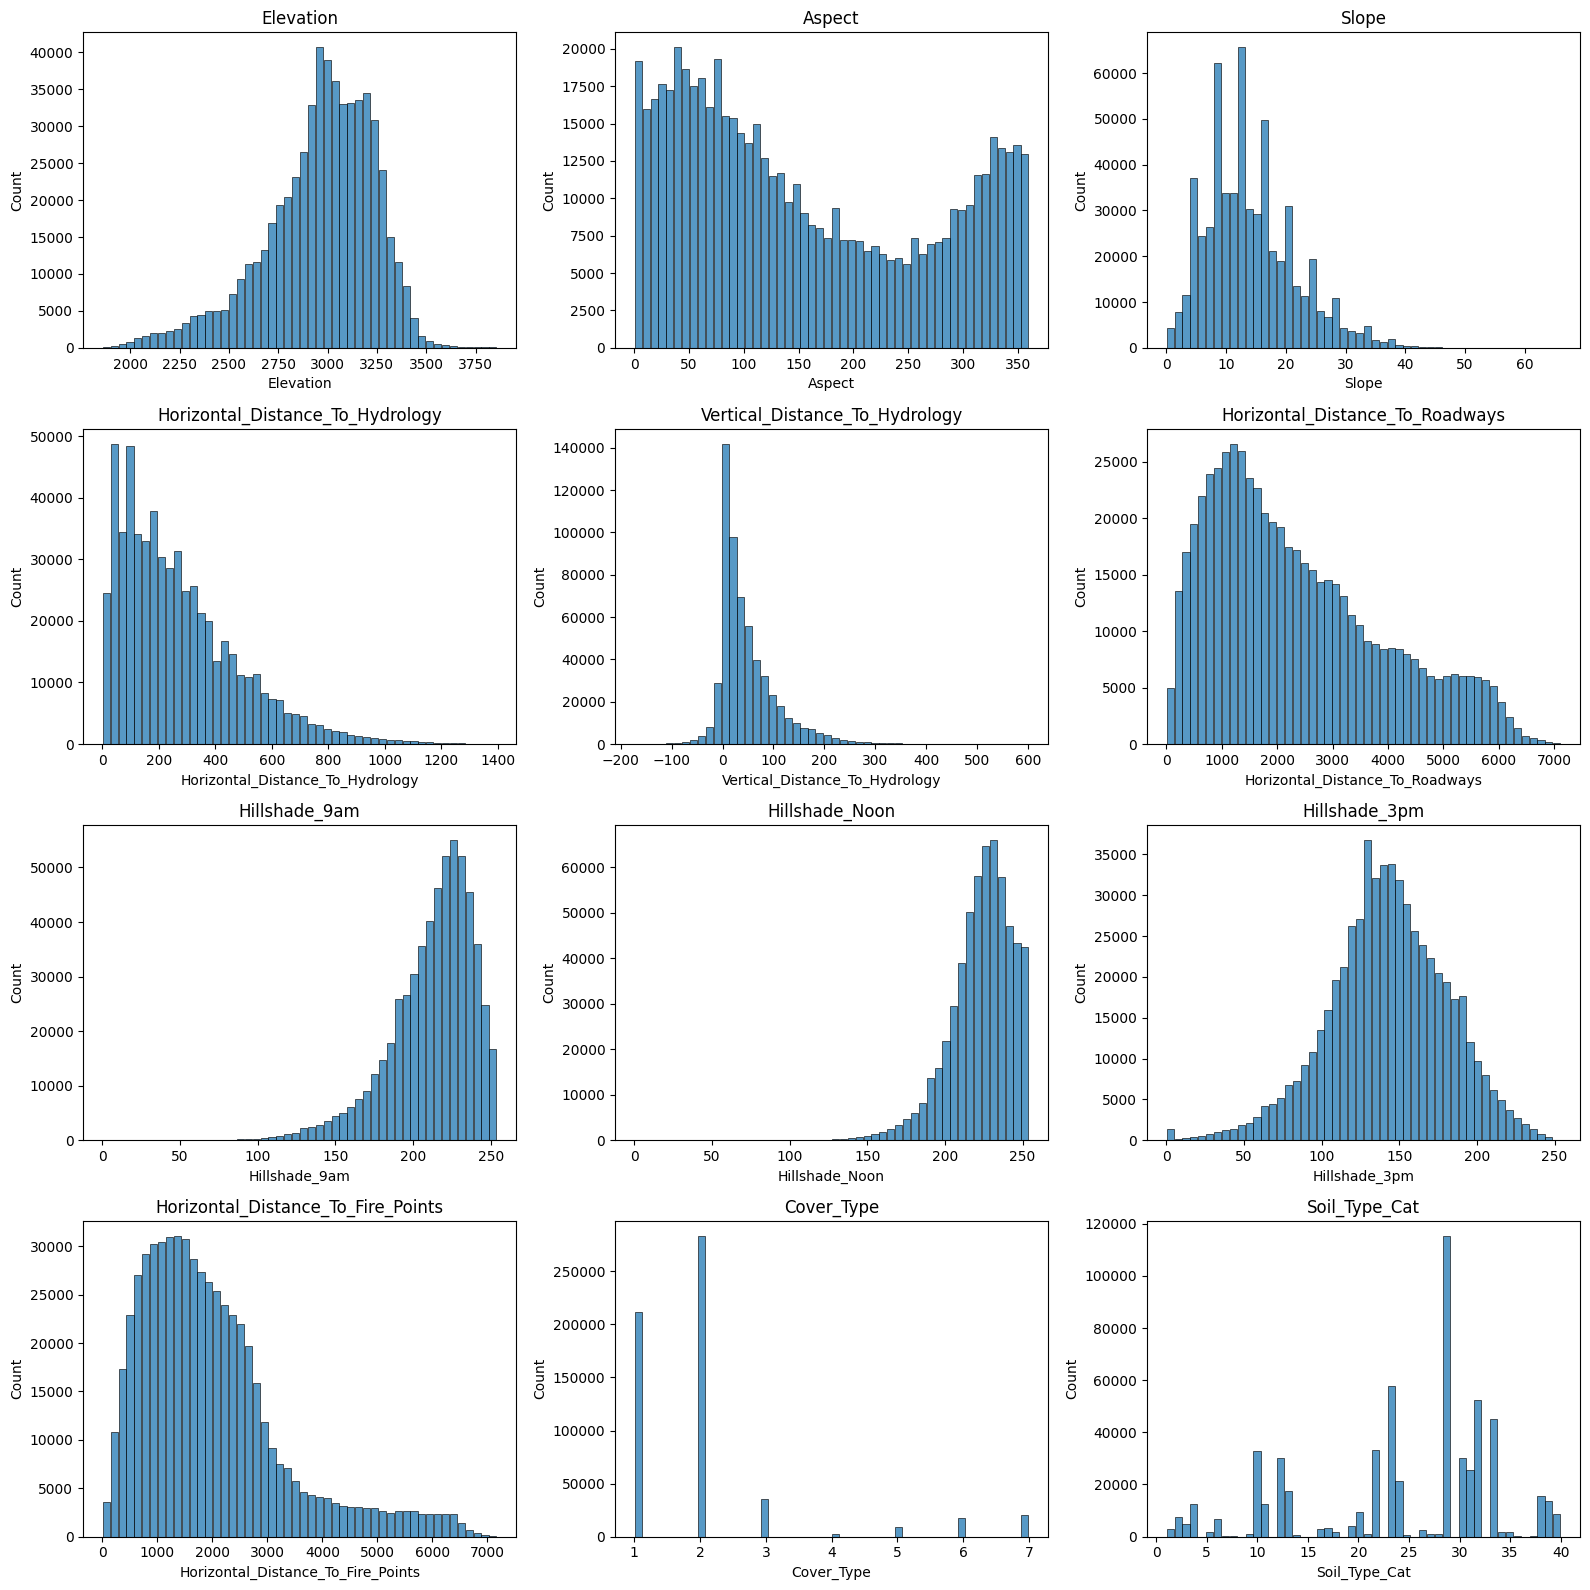

In [13]:
# Let's visualize the distribution of the non-OHE features
# There are both right and left skewed features in the dataset
# These features might need transformation before feeding them into the model for non-Tree based algorithms to both ease the training and to satisfy the assumptions of the algorithms
# However, I will be using tree-based algorithms, so I can skip the transformations for now as they are not sensitive to feature distributions

fig, axes = plt.subplots(4, 3, figsize=(16,16))
axes = axes.flatten()

for i, feature in enumerate(non_ohe_cols):
    sns.histplot(
        data=raw,
        x=feature,
        multiple="dodge",
        shrink=0.9,
        ax=axes[i],
        bins=50
    )
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

# 4. Data Preprocessing
---


* Since I will use tree based models for such a large dataset, there is no restriction to use Gaussian-like distribution of continuous features
* Categorical variables are either one-hot encoded, or label encoded
* Therefore, there will be no extra data preprocessing required for this dataset.

Classfication Algorithms to be used:

- Random Forest
- XGBoost
- LightGBM

# 5. Modelling
---

In [14]:
# Let's separate features and target variable with stratified sampling

X = raw.drop('Cover_Type', axis=1)
y = raw['Cover_Type'] - 1 # Making classes start from 0

# Let's split the data into training and testing sets with stratification as the target variable is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# I will use Optuna to perform hyperparameter optimization for three different models: RandomForest, XGBoost, and LightGBM
# The objective function required by Optuna will be defined to handle the hyperparameter tuning for each model
# Hyperparameter ranges are defined based on first common practices and then are fine tuned based on quick validation results of the ranges for specific characteristics of each model (with Optuna visualization tools)


def objective(trial, model_name, X, y):
    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_categorical('max_depth', [None, 10, 30, 50, 60])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 400, 600)
        max_depth = trial.suggest_int('max_depth', 6, 35)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
        subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
        colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
        reg_alpha = trial.suggest_float('reg_alpha', 1e-2, 1e0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-2, 1e0, log=True)
        gamma = trial.suggest_float('gamma', 1e-3, 0.5, log=True)
        objective = 'multi:softmax'
        booster = trial.suggest_categorical('booster', ['gbtree'])
        tree_method = trial.suggest_categorical('tree_method', ['gpu_hist'])
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            gamma=gamma,
            objective=objective,
            tree_method=tree_method,
            booster=booster,
            random_state=42,
            n_jobs=-1,
            verbosity=0)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 500, 1000)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 75)
        bagging_fraction = trial.suggest_categorical('bagging_fraction', [0.6, 0.7, 0.8, 0.9])
        feature_fraction = trial.suggest_categorical('feature_fraction', [0.6, 0.7, 0.8, 0.9])
        reg_alpha = trial.suggest_float('reg_alpha', 1e-2, 1e0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-2, 1e0, log=True)
        objective = 'multiclass'
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt'])
        device_type = trial.suggest_categorical('device_type', ['gpu'])
        max_bin = trial.suggest_int('max_bin', 63, 255)
        bagging_freq = 1 
        model = LGBMClassifier(
          n_estimators=n_estimators,
          learning_rate=learning_rate,
          num_leaves=num_leaves,
          subsample=bagging_fraction,        
          colsample_bytree=feature_fraction, 
          reg_alpha=reg_alpha,
          reg_lambda=reg_lambda,
          objective=objective,
          boosting_type=boosting_type,
          device=device_type,
          random_state=42,
          max_bin=max_bin,
          subsample_freq=bagging_freq
)
    else:
        raise ValueError("Model name must be 'RandomForest', 'XGBoost', or 'LightGBM'")

# 3-Fold Stratified Cross-Validation is used to evaluate the model's performance with average F1-Macro score
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, scoring='f1_macro', cv=skf, n_jobs=-1).mean()
    return score


# Optuna's HyperbandPruner for faster convergence
pruner = HyperbandPruner(min_resource=1, max_resource="auto", reduction_factor=3)

In [16]:
# Since the dataset is large, we can use a small subset of the training data for hyperparameter optimization to speed up the process
# Subsampled dataset would represent the whole dataset, however, the scores might be slightly lower than using the full dataset as significant information is lost to capture the relationships
# Yet, it is a good trade-off between speed and performance for hyperparameter 
# Eventually, the model optimized will be trained on the full data which in return will improve the f1-macro scores
# I will use 5% of the training data (27,400) for hyperparameter optimization, and will enable GPU usage for further speed

X_subsample, _ , y_subsample, _ = train_test_split(X_train, y_train, train_size=0.05, stratify=y_train, random_state=42)

# Reqyuired for LightGBM to treat categorical features appropriately
X_subsample_lgb = X_subsample.copy()
X_subsample_lgb[['Soil_Type_Cat'] + wilderness_cols] = X_subsample_lgb[['Soil_Type_Cat']+ wilderness_cols].astype("category")

# Creating a dictionary to hold model configurations
model_configs = {
    'LightGBM': {'data': X_subsample_lgb},
    'XGBoost': {'data': X_subsample},
    'RandomForest': {'data': X_subsample}
}

# Number of Trials for each model optimization (similar to epochs in neural networks)
n_trials = 25

# Recording best trials for each model
best_trials = {}



In [17]:
# Running optimization for all models
for model_name, config in model_configs.items():
    print(f'\n\nHyperparameter Optimization for {model_name}')
    print('=' * 150)
    study = optuna.create_study(
        direction='maximize', 
        pruner=pruner,
        storage="sqlite:///optuna_ordinal_v2.db",      # SQLite database to store study results
        study_name=f"{model_name}_ordinal_study_v2",   # Unique study name for each model
        load_if_exists=True                 # To continue from previous trials if they exist
    )

    # Objective function required by Optuna
    def model_objective(trial):
        return objective(trial, model_name, config['data'], y_subsample)
    
    study.optimize(
        model_objective, 
        n_trials=n_trials, 
        show_progress_bar=True
    )
    
    print(f'\nBest F1-macro: {study.best_value:.4f}')
    print('Best hyperparameters:', study.best_params)
    best_trials[model_name] = study.best_params


# Although the trials are shown as 25, the actual number of total trials is higher due to previously completed trials under the same study_name in the same optuna_ordinal_v2.db database
# Hence, it is possible that the best hyperparameters might be from any of the previous trials
# Optuna's search algorithm is benefitted from the previous trials and uses that information to find better hyperparameters in the next trial(s)
# For this case, I haven't changed any hyperparameter ranges or the number of trials between runs, so it is like continuing the same optimization process
# As a matter of fact, I forgot to change the number of trials in the previous runs :D, therefore, it is like I did partially add trials to previous runs
# But it is technically possible to add/remove hyperparameters safely between runs as long as the study_name remains the same and load_if_exists is set to True
# However, it would be problematic to change the search range as it would mislead the search algorithm and the results would be unreliable




Hyperparameter Optimization for LightGBM


[I 2025-09-16 13:37:05,151] Using an existing study with name 'LightGBM_ordinal_study_v2' instead of creating a new one.
Best trial: 23. Best value: 0.762604:   4%|▍         | 1/25 [01:02<25:00, 62.51s/it]

[I 2025-09-16 13:38:07,659] Trial 25 finished with value: 0.7507694351481362 and parameters: {'n_estimators': 550, 'learning_rate': 0.03947889287982062, 'num_leaves': 29, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.035747479245017366, 'reg_lambda': 0.6282720554050096, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 101}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:   8%|▊         | 2/25 [02:27<29:02, 75.77s/it]

[I 2025-09-16 13:39:32,710] Trial 26 finished with value: 0.745877876980087 and parameters: {'n_estimators': 721, 'learning_rate': 0.045913255998146926, 'num_leaves': 35, 'bagging_fraction': 0.7, 'feature_fraction': 0.6, 'reg_alpha': 0.0642755863754841, 'reg_lambda': 0.6512639031173103, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 84}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  12%|█▏        | 3/25 [04:26<34:57, 95.34s/it]

[I 2025-09-16 13:41:31,340] Trial 27 finished with value: 0.7483533990163949 and parameters: {'n_estimators': 808, 'learning_rate': 0.060153898270729485, 'num_leaves': 45, 'bagging_fraction': 0.6, 'feature_fraction': 0.9, 'reg_alpha': 0.02863243038658143, 'reg_lambda': 0.4591134498719731, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 104}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  16%|█▌        | 4/25 [05:22<27:57, 79.90s/it]

[I 2025-09-16 13:42:27,565] Trial 28 finished with value: 0.7568707059886609 and parameters: {'n_estimators': 645, 'learning_rate': 0.0862916930950678, 'num_leaves': 24, 'bagging_fraction': 0.8, 'feature_fraction': 0.7, 'reg_alpha': 0.07092519344236754, 'reg_lambda': 0.7743588919482223, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 120}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  20%|██        | 5/25 [06:51<27:45, 83.26s/it]

[I 2025-09-16 13:43:56,791] Trial 29 finished with value: 0.7549584674195247 and parameters: {'n_estimators': 506, 'learning_rate': 0.055707649219822374, 'num_leaves': 65, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.14869540604808304, 'reg_lambda': 0.291107396658496, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 74}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  24%|██▍       | 6/25 [09:13<32:38, 103.05s/it]

[I 2025-09-16 13:46:18,263] Trial 30 finished with value: 0.7598226478562844 and parameters: {'n_estimators': 885, 'learning_rate': 0.04302139596738907, 'num_leaves': 53, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.08084416703871501, 'reg_lambda': 0.5024490447643348, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 114}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  28%|██▊       | 7/25 [11:30<34:14, 114.12s/it]

[I 2025-09-16 13:48:35,184] Trial 31 finished with value: 0.756429536101893 and parameters: {'n_estimators': 900, 'learning_rate': 0.04660584168891084, 'num_leaves': 54, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.08769838786372787, 'reg_lambda': 0.42527647583408773, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 88}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  32%|███▏      | 8/25 [14:05<36:04, 127.34s/it]

[I 2025-09-16 13:51:10,820] Trial 32 finished with value: 0.75981263574869 and parameters: {'n_estimators': 897, 'learning_rate': 0.037025373673100964, 'num_leaves': 58, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.1257433826010678, 'reg_lambda': 0.7057617643931547, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 97}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  36%|███▌      | 9/25 [17:01<37:57, 142.35s/it]

[I 2025-09-16 13:54:06,171] Trial 33 finished with value: 0.7591302171945044 and parameters: {'n_estimators': 912, 'learning_rate': 0.036100102023503694, 'num_leaves': 66, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.07522169149764621, 'reg_lambda': 0.42108707615266394, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 111}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  40%|████      | 10/25 [19:44<37:14, 148.98s/it]

[I 2025-09-16 13:56:49,984] Trial 34 finished with value: 0.7565584242317134 and parameters: {'n_estimators': 897, 'learning_rate': 0.035144448383427056, 'num_leaves': 65, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.08316970336381582, 'reg_lambda': 0.23605670345591462, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 112}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  44%|████▍     | 11/25 [22:32<36:07, 154.80s/it]

[I 2025-09-16 13:59:37,977] Trial 35 finished with value: 0.7559037988632603 and parameters: {'n_estimators': 908, 'learning_rate': 0.02711076185183425, 'num_leaves': 57, 'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'reg_alpha': 0.02878385993391891, 'reg_lambda': 0.38188915998281103, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 131}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  48%|████▊     | 12/25 [24:58<32:56, 152.05s/it]

[I 2025-09-16 14:02:03,733] Trial 36 finished with value: 0.7457462281525352 and parameters: {'n_estimators': 867, 'learning_rate': 0.032912966689765726, 'num_leaves': 62, 'bagging_fraction': 0.6, 'feature_fraction': 0.7, 'reg_alpha': 0.13774469900779607, 'reg_lambda': 0.4849736637321403, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 122}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  52%|█████▏    | 13/25 [27:32<30:32, 152.69s/it]

[I 2025-09-16 14:04:37,914] Trial 37 finished with value: 0.7448489296841636 and parameters: {'n_estimators': 948, 'learning_rate': 0.041484661516367885, 'num_leaves': 66, 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'reg_alpha': 0.07749057361997236, 'reg_lambda': 0.1679904893544719, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 135}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  56%|█████▌    | 14/25 [30:19<28:45, 156.82s/it]

[I 2025-09-16 14:07:24,283] Trial 38 finished with value: 0.7507108191486296 and parameters: {'n_estimators': 789, 'learning_rate': 0.022851571076835973, 'num_leaves': 69, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.047817254617461245, 'reg_lambda': 0.37562549321555067, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 164}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  60%|██████    | 15/25 [32:55<26:05, 156.55s/it]

[I 2025-09-16 14:10:00,177] Trial 39 finished with value: 0.752317894752902 and parameters: {'n_estimators': 939, 'learning_rate': 0.02594339368690324, 'num_leaves': 59, 'bagging_fraction': 0.8, 'feature_fraction': 0.7, 'reg_alpha': 0.176032959112156, 'reg_lambda': 0.01680510743802045, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 64}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  64%|██████▍   | 16/25 [35:35<23:38, 157.62s/it]

[I 2025-09-16 14:12:40,309] Trial 40 finished with value: 0.7600303755739163 and parameters: {'n_estimators': 1000, 'learning_rate': 0.01735935959860734, 'num_leaves': 51, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.019402986696247522, 'reg_lambda': 0.7829441460016597, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 138}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  68%|██████▊   | 17/25 [38:10<20:56, 157.05s/it]

[I 2025-09-16 14:15:16,010] Trial 41 finished with value: 0.7469614778203765 and parameters: {'n_estimators': 995, 'learning_rate': 0.01001409029929952, 'num_leaves': 50, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.01842830452824012, 'reg_lambda': 0.7365551031508187, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 146}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  72%|███████▏  | 18/25 [40:54<18:32, 159.00s/it]

[I 2025-09-16 14:17:59,554] Trial 42 finished with value: 0.7502343824161569 and parameters: {'n_estimators': 971, 'learning_rate': 0.016241915620143127, 'num_leaves': 54, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.010857051087668011, 'reg_lambda': 0.8481750955195727, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 112}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  76%|███████▌  | 19/25 [43:24<15:37, 156.23s/it]

[I 2025-09-16 14:20:29,327] Trial 43 finished with value: 0.758514611184789 and parameters: {'n_estimators': 864, 'learning_rate': 0.03517618592849751, 'num_leaves': 53, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.02836565374960392, 'reg_lambda': 0.47572601513906726, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 77}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  80%|████████  | 20/25 [45:45<12:38, 151.62s/it]

[I 2025-09-16 14:22:50,218] Trial 44 finished with value: 0.7461568676960771 and parameters: {'n_estimators': 921, 'learning_rate': 0.011580619652228305, 'num_leaves': 47, 'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'reg_alpha': 0.014709036094827224, 'reg_lambda': 0.3097161810963893, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 129}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  84%|████████▍ | 21/25 [48:22<10:13, 153.48s/it]

[I 2025-09-16 14:25:28,025] Trial 45 finished with value: 0.7624452483862537 and parameters: {'n_estimators': 830, 'learning_rate': 0.030668556167316938, 'num_leaves': 60, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.0371823198852426, 'reg_lambda': 0.9820716824957256, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 159}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  88%|████████▊ | 22/25 [50:59<07:43, 154.47s/it]

[I 2025-09-16 14:28:04,815] Trial 46 finished with value: 0.7455685547169971 and parameters: {'n_estimators': 834, 'learning_rate': 0.019950355834565472, 'num_leaves': 60, 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'reg_alpha': 0.020009163563906907, 'reg_lambda': 0.8905801395423893, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 155}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  92%|█████████▏| 23/25 [53:34<05:09, 154.70s/it]

[I 2025-09-16 14:30:40,057] Trial 47 finished with value: 0.738101558434094 and parameters: {'n_estimators': 885, 'learning_rate': 0.013051023615169436, 'num_leaves': 56, 'bagging_fraction': 0.6, 'feature_fraction': 0.9, 'reg_alpha': 0.03627756222006573, 'reg_lambda': 0.03384227554257032, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 143}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604:  96%|█████████▌| 24/25 [55:53<02:29, 149.96s/it]

[I 2025-09-16 14:32:58,958] Trial 48 finished with value: 0.7606135718912883 and parameters: {'n_estimators': 811, 'learning_rate': 0.04266243708179653, 'num_leaves': 48, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.02428236196593312, 'reg_lambda': 0.6491290964045406, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 137}. Best is trial 23 with value: 0.7626043502195069.


Best trial: 23. Best value: 0.762604: 100%|██████████| 25/25 [57:38<00:00, 138.35s/it]
[I 2025-09-16 14:34:44,032] Using an existing study with name 'XGBoost_ordinal_study_v2' instead of creating a new one.


[I 2025-09-16 14:34:43,981] Trial 49 finished with value: 0.7460570962370142 and parameters: {'n_estimators': 714, 'learning_rate': 0.031195876365148846, 'num_leaves': 45, 'bagging_fraction': 0.7, 'feature_fraction': 0.8, 'reg_alpha': 0.025962456216068075, 'reg_lambda': 0.6047368719448781, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 206}. Best is trial 23 with value: 0.7626043502195069.

Best F1-macro: 0.7626
Best hyperparameters: {'n_estimators': 547, 'learning_rate': 0.05994012368828793, 'num_leaves': 28, 'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'reg_alpha': 0.053711044415626935, 'reg_lambda': 0.5892048068323368, 'boosting_type': 'gbdt', 'device_type': 'gpu', 'max_bin': 86}


Hyperparameter Optimization for XGBoost


Best trial: 25. Best value: 0.764188:   4%|▍         | 1/25 [01:20<32:05, 80.23s/it]

[I 2025-09-16 14:36:04,259] Trial 25 finished with value: 0.7641880076664034 and parameters: {'n_estimators': 491, 'max_depth': 18, 'learning_rate': 0.04660338931987699, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0727382580826354, 'reg_lambda': 0.16764109423384568, 'gamma': 0.003127830054580025, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 25. Best value: 0.764188:   8%|▊         | 2/25 [02:30<28:24, 74.13s/it]

[I 2025-09-16 14:37:14,115] Trial 26 finished with value: 0.7633226111725268 and parameters: {'n_estimators': 494, 'max_depth': 18, 'learning_rate': 0.07235787613223378, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.19903747376745778, 'reg_lambda': 0.11456672426408379, 'gamma': 0.0010417946650821647, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 25. Best value: 0.764188:  12%|█▏        | 3/25 [03:42<26:52, 73.28s/it]

[I 2025-09-16 14:38:26,387] Trial 27 finished with value: 0.7634630127891994 and parameters: {'n_estimators': 497, 'max_depth': 13, 'learning_rate': 0.046675509754437496, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.199321339967244, 'reg_lambda': 0.11571602311750638, 'gamma': 0.001031539706167225, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 25. Best value: 0.764188:  16%|█▌        | 4/25 [04:48<24:37, 70.36s/it]

[I 2025-09-16 14:39:32,267] Trial 28 finished with value: 0.7553676547363053 and parameters: {'n_estimators': 502, 'max_depth': 11, 'learning_rate': 0.04678608255988737, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.24342334363324414, 'reg_lambda': 0.11801333552807633, 'gamma': 0.0011335416886949729, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 25. Best value: 0.764188:  20%|██        | 5/25 [06:02<23:52, 71.65s/it]

[I 2025-09-16 14:40:46,199] Trial 29 finished with value: 0.7582220358126227 and parameters: {'n_estimators': 541, 'max_depth': 10, 'learning_rate': 0.033345684244326754, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.2662544576723206, 'reg_lambda': 0.06358134920589492, 'gamma': 0.001181390155590511, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 25. Best value: 0.764188:  24%|██▍       | 6/25 [07:26<24:02, 75.92s/it]

[I 2025-09-16 14:42:10,410] Trial 30 finished with value: 0.7617810166558486 and parameters: {'n_estimators': 496, 'max_depth': 14, 'learning_rate': 0.05169350066913872, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.19015372283699253, 'reg_lambda': 0.09737211924824418, 'gamma': 0.002161592256511191, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 25 with value: 0.7641880076664034.


Best trial: 31. Best value: 0.765302:  28%|██▊       | 7/25 [08:37<22:19, 74.39s/it]

[I 2025-09-16 14:43:21,660] Trial 31 finished with value: 0.7653017448920442 and parameters: {'n_estimators': 484, 'max_depth': 16, 'learning_rate': 0.07552797689274487, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.08773841439037558, 'reg_lambda': 0.24987121142127428, 'gamma': 0.0032171661232706815, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  32%|███▏      | 8/25 [09:23<18:28, 65.21s/it]

[I 2025-09-16 14:44:07,216] Trial 32 finished with value: 0.756384270310786 and parameters: {'n_estimators': 484, 'max_depth': 8, 'learning_rate': 0.06157304764014825, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.38501796355850254, 'reg_lambda': 0.2663772387522141, 'gamma': 0.0010559492367038968, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  36%|███▌      | 9/25 [09:57<14:47, 55.50s/it]

[I 2025-09-16 14:44:41,356] Trial 33 finished with value: 0.7279357980697837 and parameters: {'n_estimators': 505, 'max_depth': 6, 'learning_rate': 0.03383098503083596, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.08967728988524418, 'reg_lambda': 0.3679901526626879, 'gamma': 0.0034903247589711268, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  40%|████      | 10/25 [11:06<14:54, 59.64s/it]

[I 2025-09-16 14:45:50,281] Trial 34 finished with value: 0.7550473021125984 and parameters: {'n_estimators': 487, 'max_depth': 16, 'learning_rate': 0.0799362859372071, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.9059166394391899, 'reg_lambda': 0.13035581907877775, 'gamma': 0.0015845521590251354, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  44%|████▍     | 11/25 [12:33<15:51, 67.98s/it]

[I 2025-09-16 14:47:17,151] Trial 35 finished with value: 0.756058395575443 and parameters: {'n_estimators': 529, 'max_depth': 13, 'learning_rate': 0.028702496654727103, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.10142524779605866, 'reg_lambda': 0.04998145930957774, 'gamma': 0.006673427727187084, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  48%|████▊     | 12/25 [13:59<15:55, 73.47s/it]

[I 2025-09-16 14:48:43,184] Trial 36 finished with value: 0.7575440141952688 and parameters: {'n_estimators': 516, 'max_depth': 19, 'learning_rate': 0.051484859437775164, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.1846116220928449, 'reg_lambda': 0.10412163277684336, 'gamma': 0.0027363265807922384, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  52%|█████▏    | 13/25 [15:45<16:40, 83.35s/it]

[I 2025-09-16 14:50:29,285] Trial 37 finished with value: 0.7540071617586498 and parameters: {'n_estimators': 555, 'max_depth': 16, 'learning_rate': 0.035120988893463274, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.346008994785109, 'reg_lambda': 0.1456206090755582, 'gamma': 0.0015029824557682256, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  56%|█████▌    | 14/25 [16:43<13:52, 75.66s/it]

[I 2025-09-16 14:51:27,153] Trial 38 finished with value: 0.7593362365561084 and parameters: {'n_estimators': 507, 'max_depth': 12, 'learning_rate': 0.08728115704505786, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.13566580501051795, 'reg_lambda': 0.2406580992741556, 'gamma': 0.004437144384272475, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  60%|██████    | 15/25 [17:49<12:09, 72.92s/it]

[I 2025-09-16 14:52:33,735] Trial 39 finished with value: 0.7484798617901939 and parameters: {'n_estimators': 486, 'max_depth': 15, 'learning_rate': 0.04399006294119877, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.08620985349400974, 'reg_lambda': 0.07815329130201783, 'gamma': 0.009480331672610807, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  64%|██████▍   | 16/25 [19:41<12:42, 84.70s/it]

[I 2025-09-16 14:54:25,792] Trial 40 finished with value: 0.7592256540771448 and parameters: {'n_estimators': 537, 'max_depth': 20, 'learning_rate': 0.027277459917136263, 'subsample': 0.8, 'colsample_bytree': 0.9, 'reg_alpha': 0.17033729582049265, 'reg_lambda': 0.02905604502384559, 'gamma': 0.0021044940653687405, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 31. Best value: 0.765302:  68%|██████▊   | 17/25 [20:54<10:49, 81.18s/it]

[I 2025-09-16 14:55:38,789] Trial 41 finished with value: 0.7594370073032529 and parameters: {'n_estimators': 476, 'max_depth': 18, 'learning_rate': 0.07282693588733674, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.07395710140608562, 'reg_lambda': 0.16308557864251588, 'gamma': 0.002539412068797255, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 31 with value: 0.7653017448920442.


Best trial: 42. Best value: 0.76664:  72%|███████▏  | 18/25 [22:07<09:10, 78.69s/it] 

[I 2025-09-16 14:56:51,667] Trial 42 finished with value: 0.7666402813662124 and parameters: {'n_estimators': 524, 'max_depth': 16, 'learning_rate': 0.07558637846816446, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.11681009276168276, 'reg_lambda': 0.19801141457509908, 'gamma': 0.003313096835407464, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  76%|███████▌  | 19/25 [23:19<07:39, 76.57s/it]

[I 2025-09-16 14:58:03,294] Trial 43 finished with value: 0.7609982824703465 and parameters: {'n_estimators': 522, 'max_depth': 13, 'learning_rate': 0.06537915549595835, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.11979233070321986, 'reg_lambda': 0.22659587967716951, 'gamma': 0.0014407421541667066, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  80%|████████  | 20/25 [24:13<05:49, 69.97s/it]

[I 2025-09-16 14:58:57,891] Trial 44 finished with value: 0.7631405743083003 and parameters: {'n_estimators': 495, 'max_depth': 16, 'learning_rate': 0.09886837039961421, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.22521158910432768, 'reg_lambda': 0.10783058317864683, 'gamma': 0.003926560096752493, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  84%|████████▍ | 21/25 [25:12<04:26, 66.63s/it]

[I 2025-09-16 14:59:56,740] Trial 45 finished with value: 0.7412523439576081 and parameters: {'n_estimators': 510, 'max_depth': 10, 'learning_rate': 0.0789258631191932, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.14571891806030415, 'reg_lambda': 0.32176399105904246, 'gamma': 0.006333546084112223, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  88%|████████▊ | 22/25 [26:30<03:30, 70.01s/it]

[I 2025-09-16 15:01:14,635] Trial 46 finished with value: 0.7574249491278827 and parameters: {'n_estimators': 526, 'max_depth': 14, 'learning_rate': 0.05670151369186801, 'subsample': 0.6, 'colsample_bytree': 1.0, 'reg_alpha': 0.1133664128624207, 'reg_lambda': 0.13966668216253333, 'gamma': 0.008594056597828829, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  92%|█████████▏| 23/25 [28:58<03:07, 93.52s/it]

[I 2025-09-16 15:03:42,972] Trial 47 finished with value: 0.7286687360350178 and parameters: {'n_estimators': 492, 'max_depth': 19, 'learning_rate': 0.010148864961669996, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0.3418822424922095, 'reg_lambda': 0.08077097802984701, 'gamma': 0.0017379004685807297, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664:  96%|█████████▌| 24/25 [29:57<01:23, 83.03s/it]

[I 2025-09-16 15:04:41,549] Trial 48 finished with value: 0.7434525904178635 and parameters: {'n_estimators': 566, 'max_depth': 15, 'learning_rate': 0.023408595397036373, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.09922837221699304, 'reg_lambda': 0.05734000508483921, 'gamma': 0.40673279558610137, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.


Best trial: 42. Best value: 0.76664: 100%|██████████| 25/25 [31:07<00:00, 74.71s/it]
[I 2025-09-16 15:05:51,982] Using an existing study with name 'RandomForest_ordinal_study_v2' instead of creating a new one.


[I 2025-09-16 15:05:51,885] Trial 49 finished with value: 0.7577823514041985 and parameters: {'n_estimators': 480, 'max_depth': 12, 'learning_rate': 0.03709657608064512, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.05197268274077392, 'reg_lambda': 0.2035507319163979, 'gamma': 0.005169358580779412, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}. Best is trial 42 with value: 0.7666402813662124.

Best F1-macro: 0.7666
Best hyperparameters: {'n_estimators': 524, 'max_depth': 16, 'learning_rate': 0.07558637846816446, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.11681009276168276, 'reg_lambda': 0.19801141457509908, 'gamma': 0.003313096835407464, 'booster': 'gbtree', 'tree_method': 'gpu_hist'}


Hyperparameter Optimization for RandomForest


Best trial: 14. Best value: 0.71236:   4%|▍         | 1/25 [00:06<02:41,  6.72s/it]

[I 2025-09-16 15:05:58,700] Trial 25 finished with value: 0.7083893550779666 and parameters: {'n_estimators': 218, 'max_depth': 50}. Best is trial 14 with value: 0.7123599131858144.


Best trial: 14. Best value: 0.71236:   8%|▊         | 2/25 [00:10<02:00,  5.25s/it]

[I 2025-09-16 15:06:02,917] Trial 26 finished with value: 0.7121362548281948 and parameters: {'n_estimators': 144, 'max_depth': 30}. Best is trial 14 with value: 0.7123599131858144.


Best trial: 14. Best value: 0.71236:  12%|█▏        | 3/25 [00:15<01:51,  5.06s/it]

[I 2025-09-16 15:06:07,753] Trial 27 finished with value: 0.7096518841491264 and parameters: {'n_estimators': 106, 'max_depth': 60}. Best is trial 14 with value: 0.7123599131858144.


Best trial: 14. Best value: 0.71236:  16%|█▌        | 4/25 [00:22<02:04,  5.91s/it]

[I 2025-09-16 15:06:14,956] Trial 28 finished with value: 0.7113187765983829 and parameters: {'n_estimators': 213, 'max_depth': 60}. Best is trial 14 with value: 0.7123599131858144.


Best trial: 29. Best value: 0.712367:  20%|██        | 5/25 [00:27<01:49,  5.45s/it]

[I 2025-09-16 15:06:19,598] Trial 29 finished with value: 0.7123669947489821 and parameters: {'n_estimators': 158, 'max_depth': 30}. Best is trial 29 with value: 0.7123669947489821.


Best trial: 29. Best value: 0.712367:  24%|██▍       | 6/25 [00:40<02:33,  8.07s/it]

[I 2025-09-16 15:06:32,768] Trial 30 finished with value: 0.7083749553131161 and parameters: {'n_estimators': 496, 'max_depth': 50}. Best is trial 29 with value: 0.7123669947489821.


Best trial: 31. Best value: 0.71276:  28%|██▊       | 7/25 [00:45<02:03,  6.87s/it] 

[I 2025-09-16 15:06:37,152] Trial 31 finished with value: 0.7127595296876229 and parameters: {'n_estimators': 157, 'max_depth': 30}. Best is trial 31 with value: 0.7127595296876229.


Best trial: 32. Best value: 0.713172:  32%|███▏      | 8/25 [00:51<01:53,  6.67s/it]

[I 2025-09-16 15:06:43,382] Trial 32 finished with value: 0.7131719757133687 and parameters: {'n_estimators': 240, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  36%|███▌      | 9/25 [00:58<01:47,  6.71s/it]

[I 2025-09-16 15:06:50,180] Trial 33 finished with value: 0.7125845690405807 and parameters: {'n_estimators': 263, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  40%|████      | 10/25 [01:04<01:40,  6.67s/it]

[I 2025-09-16 15:06:56,774] Trial 34 finished with value: 0.7121681324469122 and parameters: {'n_estimators': 256, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  44%|████▍     | 11/25 [01:14<01:47,  7.68s/it]

[I 2025-09-16 15:07:06,726] Trial 35 finished with value: 0.7104588800429638 and parameters: {'n_estimators': 392, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  48%|████▊     | 12/25 [01:19<01:28,  6.84s/it]

[I 2025-09-16 15:07:11,665] Trial 36 finished with value: 0.7113195418250703 and parameters: {'n_estimators': 193, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  52%|█████▏    | 13/25 [01:25<01:20,  6.67s/it]

[I 2025-09-16 15:07:17,928] Trial 37 finished with value: 0.6192414461620431 and parameters: {'n_estimators': 403, 'max_depth': 10}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  56%|█████▌    | 14/25 [01:39<01:37,  8.90s/it]

[I 2025-09-16 15:07:31,973] Trial 38 finished with value: 0.7079398574371774 and parameters: {'n_estimators': 547, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  60%|██████    | 15/25 [01:46<01:22,  8.23s/it]

[I 2025-09-16 15:07:38,671] Trial 39 finished with value: 0.7131206738189647 and parameters: {'n_estimators': 255, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  64%|██████▍   | 16/25 [01:50<01:03,  7.02s/it]

[I 2025-09-16 15:07:42,872] Trial 40 finished with value: 0.6171838957832692 and parameters: {'n_estimators': 260, 'max_depth': 10}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  68%|██████▊   | 17/25 [01:58<00:58,  7.30s/it]

[I 2025-09-16 15:07:50,832] Trial 41 finished with value: 0.7104641225412299 and parameters: {'n_estimators': 290, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  72%|███████▏  | 18/25 [02:03<00:45,  6.50s/it]

[I 2025-09-16 15:07:55,453] Trial 42 finished with value: 0.7112459638455825 and parameters: {'n_estimators': 175, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  76%|███████▌  | 19/25 [02:09<00:38,  6.42s/it]

[I 2025-09-16 15:08:01,699] Trial 43 finished with value: 0.711382117876492 and parameters: {'n_estimators': 226, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  80%|████████  | 20/25 [02:27<00:49,  9.96s/it]

[I 2025-09-16 15:08:19,894] Trial 44 finished with value: 0.7083627023911802 and parameters: {'n_estimators': 710, 'max_depth': None}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  84%|████████▍ | 21/25 [02:31<00:32,  8.04s/it]

[I 2025-09-16 15:08:23,449] Trial 45 finished with value: 0.7121604335021918 and parameters: {'n_estimators': 127, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  88%|████████▊ | 22/25 [02:36<00:21,  7.08s/it]

[I 2025-09-16 15:08:28,304] Trial 46 finished with value: 0.7101092848307475 and parameters: {'n_estimators': 189, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  92%|█████████▏| 23/25 [02:40<00:12,  6.25s/it]

[I 2025-09-16 15:08:32,602] Trial 47 finished with value: 0.7117317493477556 and parameters: {'n_estimators': 159, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172:  96%|█████████▌| 24/25 [02:48<00:06,  6.85s/it]

[I 2025-09-16 15:08:40,872] Trial 48 finished with value: 0.7128073112121172 and parameters: {'n_estimators': 316, 'max_depth': 30}. Best is trial 32 with value: 0.7131719757133687.


Best trial: 32. Best value: 0.713172: 100%|██████████| 25/25 [02:57<00:00,  7.08s/it]

[I 2025-09-16 15:08:48,985] Trial 49 finished with value: 0.7115680701101081 and parameters: {'n_estimators': 317, 'max_depth': None}. Best is trial 32 with value: 0.7131719757133687.

Best F1-macro: 0.7132
Best hyperparameters: {'n_estimators': 240, 'max_depth': 30}


In [18]:
model_lgbm = LGBMClassifier(
          **best_trials['LightGBM'],    # Unpacking the best parameters
          objective='multiclass',
          random_state=42,
          subsample_freq=1,             # Required when bagging_fraction < 1.0
          verbose=-1                    
)

model_xgbo = XGBClassifier(
          **best_trials['XGBoost'],     # Unpacking the best parameters
          objective='multiclass',
          random_state=42,
          subsample_freq=1,             # Required when bagging_fraction < 1.0
)

model_rf = RandomForestClassifier(
          **best_trials['RandomForest'], # Unpacking the best parameters
          random_state=42
)

# 6. Results
---

In [19]:
# Transformation of categorical features for LightGBM
X_train_categorical = X_train.copy()
X_train_categorical[['Soil_Type_Cat'] + wilderness_cols] = X_train_categorical[['Soil_Type_Cat'] + wilderness_cols].astype("category")

models = {'LightGBM': model_lgbm, 'XGBoost': model_xgbo, 'RandomForest': model_rf}
model_performance = {}
y_pred_dict = {}

for name, model in models.items():
    print(f'Fitting {name}...')
    if name == 'LightGBM':
        model.fit(X_train_categorical, y_train)
        # Transformation of categorical features for LightGBM test set
        X_test_categorical = X_test.copy()
        X_test_categorical[['Soil_Type_Cat'] + wilderness_cols] = X_test_categorical[['Soil_Type_Cat'] + wilderness_cols].astype("category")
        y_pred_dict[name] = model.predict(X_test_categorical)
    else:
        model.fit(X_train, y_train)
        y_pred_dict[name] = model.predict(X_test)

Fitting LightGBM...
Fitting XGBoost...
Fitting RandomForest...


In [ ]:
# F1-Macro Score Evaluation
for name, y_pred in y_pred_dict.items():
    f1_macro_test = f1_score(y_test, y_pred, average='macro')
    model_performance[name] = f1_macro_test
    print(f"F1-Macro Score for {name}: {f1_macro_test:.4f}\n")

# I chose F1-Macro score as the evaluation metric because the dataset is imbalanced and it is a multi-class classification problem
# It seems that all performed above 0.90 which is a competitive score
# Among all modes, XGBoost performed the best with a F1-Macro score

F1-Macro Score for LightGBM: 0.9000

F1-Macro Score for XGBoost: 0.9489

F1-Macro Score for RandomForest: 0.9302



In [22]:
y_pred_xgbo= y_pred_dict['XGBoost']  

# XGBoost Classification Report
print(classification_report(y_test, y_pred_xgbo))

# As a final evaluation, I will print the classification report for the best performing model, which is XGBoost in this case (Other models are also competitive!)
# Since class 3 and class 4 are the least frequent classes, their precision and recall are slightly lower than other classes, which is expected in imbalanced datasets, however, they are still quite good (> 0.90)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     42368
           1       0.97      0.98      0.98     56661
           2       0.97      0.97      0.97      7151
           3       0.90      0.88      0.89       549
           4       0.94      0.90      0.92      1899
           5       0.95      0.94      0.95      3473
           6       0.97      0.97      0.97      4102

    accuracy                           0.97    116203
   macro avg       0.95      0.94      0.95    116203
weighted avg       0.97      0.97      0.97    116203



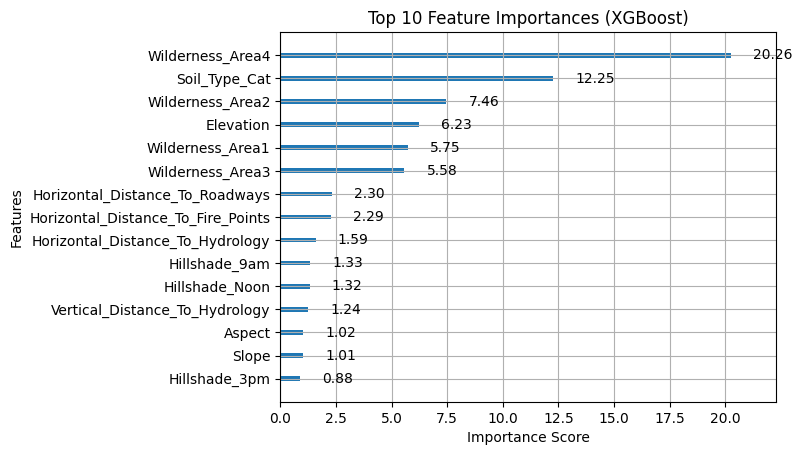

In [ ]:
from xgboost import plot_importance

plot_importance(model_xgbo, importance_type='gain', title='Top 10 Feature Importances (XGBoost)', xlabel='Importance Score', ylabel='Features',values_format="{v:.2f}", grid=False)
plt.show()

# As it can be seen Wilderness Area, Soil Type, and Elevation are among the most important features in determining the Cover Type
# This aligns with our earlier observations during the exploratory data analysis (EDA) phase, where we noted the significance of these features in relation to the target variable.